In [1]:
from google.colab import files
uploaded_1 = files.upload()

Saving articles.csv to articles.csv


In [2]:
uploaded_2 = files.upload()

Saving transactions-2p-42.csv to transactions-2p-42.csv


In [3]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spark = SparkSession.builder.appName("Midterm Big Data").getOrCreate()

df_tr = spark.read.csv("transactions-2p-42.csv", header=True, inferSchema=True)
df_art = spark.read.csv("articles.csv", header=True, inferSchema=True)

In [6]:
df_tr = df_tr.withColumn("t_dat", F.to_date(F.col("t_dat"), "yyyy-MM-dd"))
df = df_tr.join(df_art, on="article_id", how="left")
df.show(5)

+----------+----------+--------------------+------------------+----------------+------------+--------------------+---------------+-----------------+------------------+-----------------------+-------------------------+-----------------+-----------------+-------------------------+---------------------------+--------------------------+----------------------------+-------------+--------------------+----------+--------------------+--------------+----------------+----------+--------------------+----------------+------------------+--------------------+
|article_id|     t_dat|         customer_id|             price|sales_channel_id|product_code|           prod_name|product_type_no|product_type_name|product_group_name|graphical_appearance_no|graphical_appearance_name|colour_group_code|colour_group_name|perceived_colour_value_id|perceived_colour_value_name|perceived_colour_master_id|perceived_colour_master_name|department_no|     department_name|index_code|          index_name|index_group_no|ind

In [16]:
df = df.withColumn("month", F.month("t_dat")) \
       .withColumn("year", F.year("t_dat")) \
       .withColumn(
           "season",
           F.when(F.col("month").isin(12, 1, 2), "Winter")
            .when(F.col("month").isin(3, 4, 5), "Spring")
            .when(F.col("month").isin(6, 7, 8), "Summer")
            .when(F.col("month").isin(9, 10, 11), "Autumn")
       )

df = df.withColumn(
    "season_order",
    F.when(F.col("season") == "Winter", 1)
     .when(F.col("season") == "Spring", 2)
     .when(F.col("season") == "Summer", 3)
     .when(F.col("season") == "Autumn", 4)
)

df.groupBy("season", "season_order") \
  .agg(
        F.count("*").alias("transactions"),
        F.sum("price").alias("revenue"),
        F.countDistinct("customer_id").alias("unique_customers"),
        F.avg("price").alias("avg_price")
    ) \
  .orderBy("season_order") \
  .drop("season_order") \
  .show()

+------+------------+------------------+----------------+--------------------+
|season|transactions|           revenue|unique_customers|           avg_price|
+------+------------+------------------+----------------+--------------------+
|Winter|       71353|1953.4234745763576|           61617|0.027376893397283334|
|Spring|       85977| 2459.363118644189|           72586|0.028604895712157775|
|Summer|       99222|2387.0828813560347|           82966|0.024058000053980313|
|Autumn|       79526| 2441.777796610208|           68668|0.030704144513872295|
+------+------------+------------------+----------------+--------------------+



**Summary**

*   *Winter* has the lowest number of transactions (71,353) and the fewest unique customers (61,617), generating the lowest revenue (1,953).
*   *Spring* has slightly fewer transactions than Summer but generates the highest revenue (2,459), with 72,586 unique customers.
*   *Summer* has the most transactions (99,222) and the most unique customers (82,966), but the average price per transaction is the lowest (0.024).
*   *Autumn* has fewer transactions than Summer (79,526) but the highest average price per transaction (0.031), and 68,668 unique customers.

This can all be visualized more clearly in the following three consecutive charts.

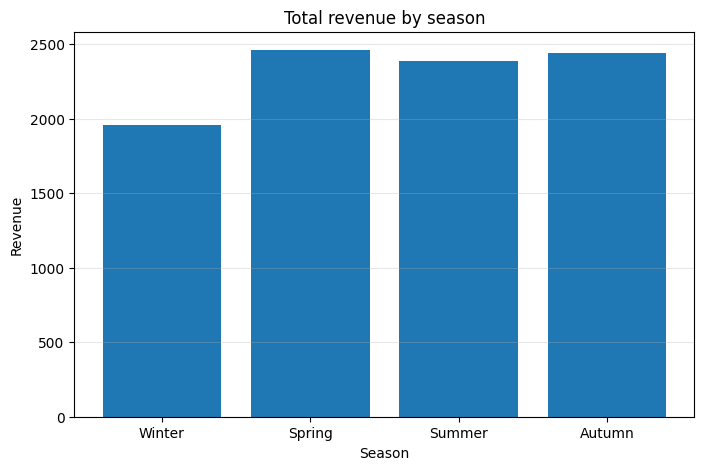

In [19]:
df_viz = df.groupBy("season", "season_order") \
           .agg(
               F.count("*").alias("transactions"),
               F.sum("price").alias("revenue"),
               F.countDistinct("customer_id").alias("unique_customers"),
               F.avg("price").alias("avg_price")
           ) \
           .orderBy("season_order")

season_pd = df_viz.toPandas()
plt.figure(figsize=(8,5))
plt.bar(season_pd["season"], season_pd["revenue"])

plt.title("Total revenue by season")
plt.xlabel("Season")
plt.ylabel("Revenue")
plt.grid(axis="y", alpha=0.3)

plt.show()

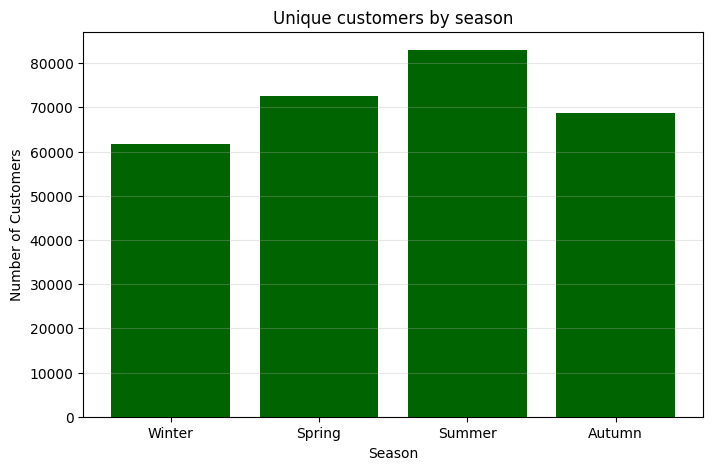

In [20]:
plt.figure(figsize=(8,5))
plt.bar(season_pd["season"], season_pd["unique_customers"], color="darkgreen")
plt.title("Unique customers by season")
plt.xlabel("Season")
plt.ylabel("Number of Customers")
plt.grid(axis="y", alpha=0.3)
plt.show()

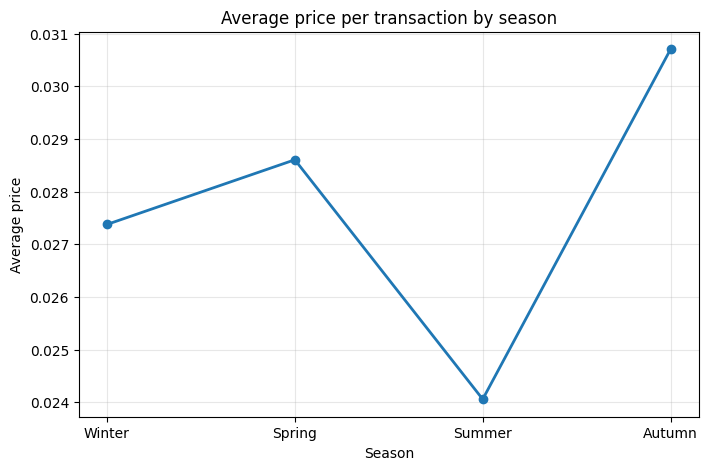

In [21]:
plt.figure(figsize=(8,5))
plt.plot(season_pd["season"], season_pd["avg_price"], marker="o", linewidth=2)

plt.title("Average price per transaction by season")
plt.xlabel("Season")
plt.ylabel("Average price")
plt.grid(alpha=0.3)
plt.show()

**Conclusion**

Customer purchasing behavior is strongly affected by seasonality. While Summer drives volume and customer engagement, Autumn generates higher-value purchases per transaction. Customer activity peaks in Summer, revenue peaks in Spring, and transaction value peaks in Autumn, while Winter is the slowest season.

In [51]:
from pyspark.sql.functions import concat_ws

month_stats = df.groupBy("year", "month") \
    .agg(
        F.count("*").alias("transactions"),
        F.sum("price").alias("revenue"),
        F.countDistinct("customer_id").alias("unique_customers"),
        F.avg("price").alias("avg_price")
    ) \
    .orderBy("year", "month")

month_stats = month_stats.withColumn(
    "year_month",
    concat_ws("_", F.col("year"), F.col("month"))
)

month_stats.show()

+----+-----+------------+-----------------+----------------+--------------------+----------+
|year|month|transactions|          revenue|unique_customers|           avg_price|year_month|
+----+-----+------------+-----------------+----------------+--------------------+----------+
|2018|    9|       12035| 362.120084745764|           11165|0.030088914395161113|    2018_9|
|2018|   10|       28124|840.4624576271059|           25573|0.029884172152862532|   2018_10|
|2018|   11|       25711| 788.927610169485|           23608| 0.03068443896268076|   2018_11|
|2018|   12|       23118|653.1888305084776|           21198| 0.02825455621197671|   2018_12|
|2019|    1|       25344|674.2764745762721|           22994|0.026604974533470334|    2019_1|
|2019|    2|       22891|625.9581694915173|           20917|0.027345164889760923|    2019_2|
|2019|    3|       25670|751.4301016949114|           23280|0.029272695819825143|    2019_3|
|2019|    4|       29107|  845.35033898304|           26229|0.02904285

**Summary**



*   *2018 Autumn* - Most active period in 2018 with 66,870 transactions, revenue 1,991 and 58,346 unique customers.
*   *2018 Winter* - Lowest activity in 2018: 23,118 transactions, revenue 653, 21,198 customers.
*   *2019 Spring* - Very active: 85,077 transactions, revenue 2,459, 77,650 customers, average price 0.0289.
*   *2019 Summer* - High volume but slightly lower revenue per transaction: 73,222 transactions, revenue 1,829., average price 0.025.
*   *2019 Autumn* - Very low activity: 13,656 transactions, revenue 450, 12,702 customers, highest average price 0.033, indicating fewer but higher-value transactions.

This can all be visualized more clearly in the following consecutive charts.


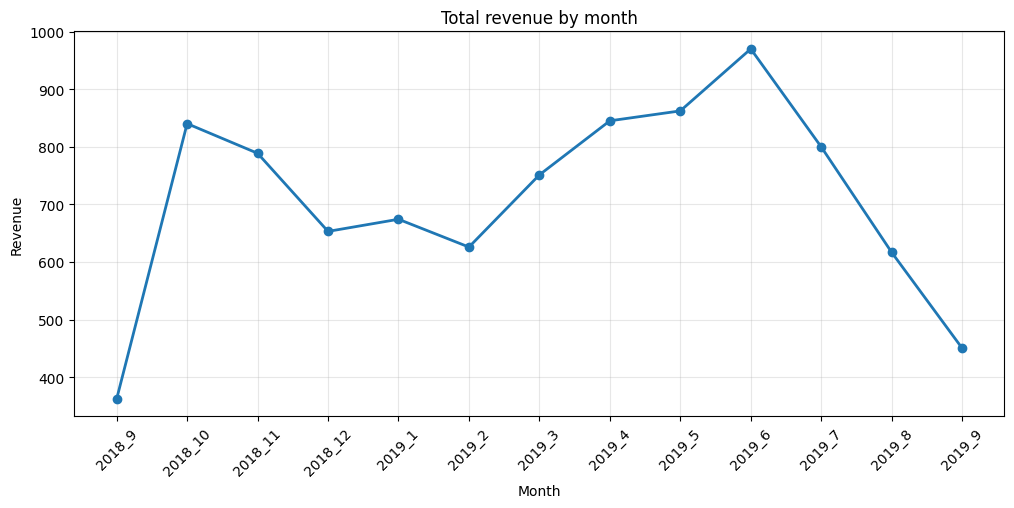

In [37]:
month_pd = month_stats.toPandas()

plt.figure(figsize=(12,5))
plt.plot(month_pd["year_month"], month_pd["revenue"], marker="o", linewidth=2)

plt.title("Total revenue by month")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.show()

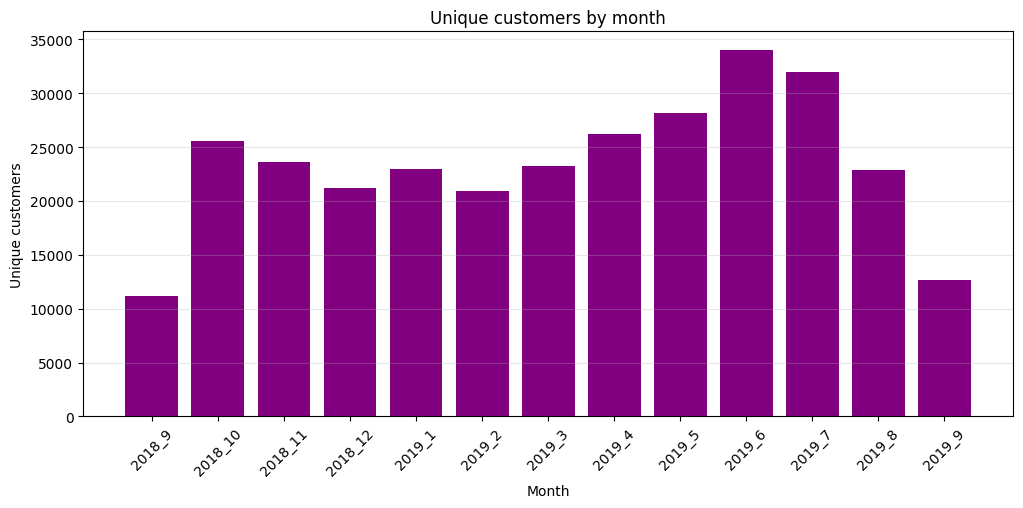

In [38]:
plt.figure(figsize=(12,5))
plt.bar(month_pd["year_month"], month_pd["unique_customers"], color="purple")
plt.title("Unique customers by month")
plt.xlabel("Month")
plt.ylabel("Unique customers")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

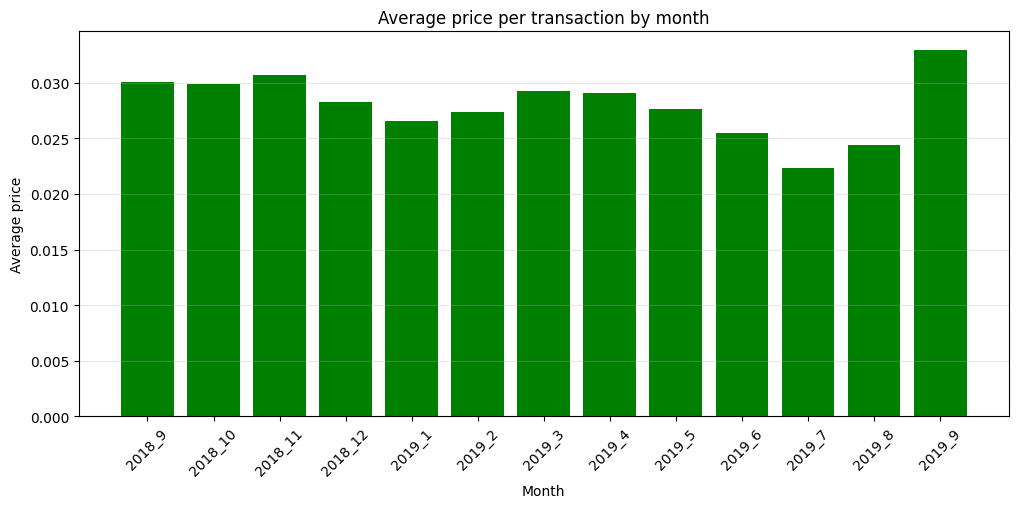

In [39]:
plt.figure(figsize=(12,5))
plt.bar(month_pd["year_month"], month_pd["avg_price"], color="green")
plt.title("Average price per transaction by month")
plt.xlabel("Month")
plt.ylabel("Average price")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

**Conclusion 1**

The monthly view and the seasonal view are just different ways of presenting the same data and show consistent trends:

* *Winter* (Dec–Feb) has moderate transactions and revenue, average price 0.0274.

* *Spring* (Mar–May) shows high revenue (2,459) and 85,077 transactions.

* *Summer* (Jun–Aug) has the highest number of transactions (99,222) but slightly lower average price (0.0241).

* *Autumn* (Sep–Nov) shows 79,526 transactions, revenue 2,442, and the highest average price (0.0307).

In [49]:
month_stats = df.groupBy("year", "month") \
    .agg(
        F.count("*").alias("transactions"),  # number of transactions in sample
        F.sum("price").alias("month_revenue"),  # revenue in sample
        F.countDistinct("customer_id").alias("customer"),  # unique customers in sample
        F.avg("price").alias("avg_expense_per_customer")  # avg price per transaction in sample
    ) \
    .orderBy("year", "month")

month_stats = month_stats.withColumn(
    "year_month",
    concat_ws("_", F.col("year"), F.col("month"))
)

scale = 1 / 0.03

month_stats = month_stats.withColumn(
    "estimated_month_revenue", F.col("month_revenue") * scale
).withColumn(
    "estimated_avg_expense_per_customer", F.col("estimated_month_revenue") / (df.select("customer_id").distinct().count() * scale)
).withColumn(
    "estimated_transactions", F.col("transactions") * scale
).withColumn(
    "estimated_customer", F.col("customer") * scale
)

month_stats.select(
    "year_month",
    F.round("month_revenue", 2).alias("month_revenue"),
    F.round("estimated_month_revenue", 2).alias("estimated_month_revenue"),
    F.round("avg_expense_per_customer", 4).alias("avg_expense_per_customer"),
    F.round("estimated_avg_expense_per_customer", 4).alias("estimated_avg_expense_per_customer"),
    "transactions",
    F.round("estimated_transactions", 2).alias("estimated_transactions"),
    "customer",
    F.round("estimated_customer", 2).alias("estimated_customer")
).show()

+----------+-------------+-----------------------+------------------------+----------------------------------+------------+----------------------+--------+------------------+
|year_month|month_revenue|estimated_month_revenue|avg_expense_per_customer|estimated_avg_expense_per_customer|transactions|estimated_transactions|customer|estimated_customer|
+----------+-------------+-----------------------+------------------------+----------------------------------+------------+----------------------+--------+------------------+
|    2018_9|       362.12|               12070.67|                  0.0301|                            0.0016|       12035|             401166.67|   11165|         372166.67|
|   2018_10|       840.46|               28015.42|                  0.0299|                            0.0036|       28124|             937466.67|   25573|         852433.33|
|   2018_11|       788.93|               26297.59|                  0.0307|                            0.0034|       25711|  

**Conclusion 2**

* *month_revenue*: Sample revenue per month
* *estimated_month_revenue*: Approximate total revenue for the entire population
* *avg_expense_per_customer*: Average expense per transaction in the sample.
* *estimated_avg_expense_per_customer*: Estimated average expense per customer in the full population.
* *transactions*: Number of transactions in the sample.
* *estimated_transactions*: Approximate total transactions in the population.
* *customer*: Unique customers in the sample.
* *estimated_customer*: Approximate total customers in the population.

The table provides both monthly metrics from the sample and scaled estimates for the whole population.

Using this methodology, I can approximate revenue, transactions, number of customers, and average customer expenses for the entire dataset, without having access to all the data.

These estimates are essential for trend analysis, seasonal comparisons, and business planning, as they allow me to see how activity varies month by month and identify high or low periods.

In [53]:
null_report = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns
])
null_report.show(truncate=False)

+----------+-----+-----------+-----+----------------+------------+---------+---------------+-----------------+------------------+-----------------------+-------------------------+-----------------+-----------------+-------------------------+---------------------------+--------------------------+----------------------------+-------------+---------------+----------+----------+--------------+----------------+----------+------------+----------------+------------------+-----------+-----+----+------+------------+
|article_id|t_dat|customer_id|price|sales_channel_id|product_code|prod_name|product_type_no|product_type_name|product_group_name|graphical_appearance_no|graphical_appearance_name|colour_group_code|colour_group_name|perceived_colour_value_id|perceived_colour_value_name|perceived_colour_master_id|perceived_colour_master_name|department_no|department_name|index_code|index_name|index_group_no|index_group_name|section_no|section_name|garment_group_no|garment_group_name|detail_desc|month|

In [54]:
missing_articles = df.filter(F.col("prod_name").isNull()).count()
missing_articles

0

In [55]:
price_stats = df.select(
    F.min("price").alias("min_price"),
    F.expr("percentile(price, 0.5)").alias("median_price"),
    F.expr("percentile(price, 0.99)").alias("p99_price"),
    F.max("price").alias("max_price")
)

price_stats.show()

+-----------------+------------------+------------------+------------------+
|        min_price|      median_price|         p99_price|         max_price|
+-----------------+------------------+------------------+------------------+
|1.864406779661E-4|0.0250338983050847|0.1016779661016949|0.5067796610169492|
+-----------------+------------------+------------------+------------------+



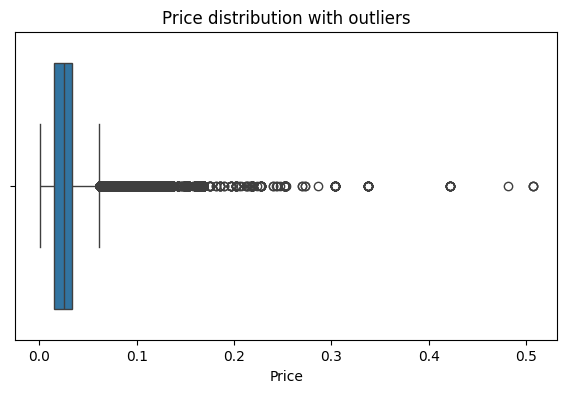

In [57]:
price_pd = df.select("price").toPandas()

plt.figure(figsize=(7,4))
sns.boxplot(x=price_pd["price"])
plt.title("Price distribution with outliers")
plt.xlabel("Price")
plt.show()

In [58]:
duplicate_rows = df.groupBy(df.columns).count().filter("count > 1").count()
duplicate_rows

895

In [59]:
df.select(
    F.min("t_dat").alias("min_date"),
    F.max("t_dat").alias("max_date")
).show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2018-09-20|2019-09-19|
+----------+----------+



**Conclusion 3**

The dataset demonstrates high overall quality. Except for detail_desc, which has 1,948 missing values, all other columns are complete. There are no join mismatches, as all transactions have valid product metadata. Price shows a few outliers (maximum 0.507 vs median 0.025), indicating rare high-value items, while duplicate transactions are minimal (895 out of 336,078). The transaction dates are consistent, spanning exactly 1 year from 2018-09-20 to 2019-09-19.

In [60]:
loyalty = df.groupBy("product_group_name", "customer_id") \
            .count() \
            .filter("count > 1") \
            .groupBy("product_group_name") \
            .count() \
            .orderBy(F.desc("count"))

loyalty.show()

+------------------+-----+
|product_group_name|count|
+------------------+-----+
|Garment Upper body|18350|
|Garment Lower body| 7750|
| Garment Full body| 2805|
|          Swimwear| 2323|
|         Underwear| 1551|
|       Accessories|  625|
|             Shoes|  334|
|    Socks & Tights|  191|
|         Nightwear|   63|
|           Unknown|    4|
+------------------+-----+



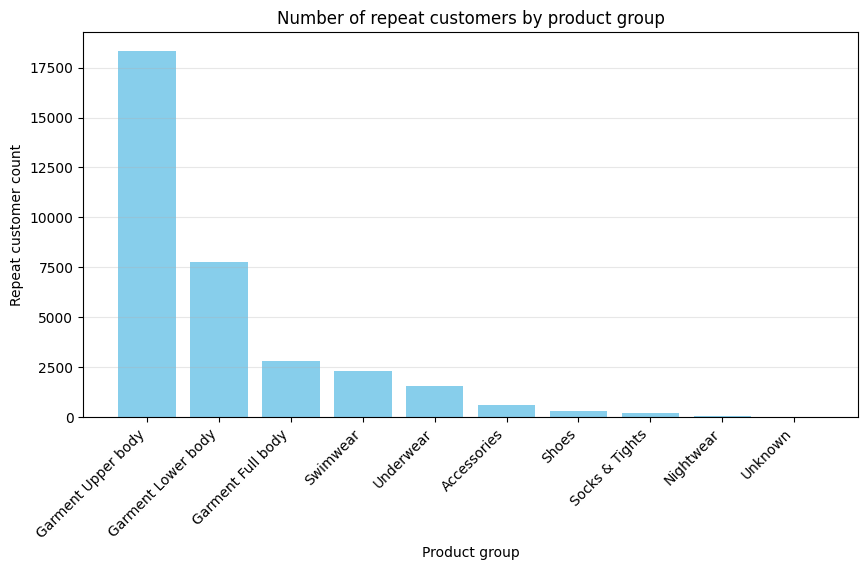

In [66]:
loyalty_pd = loyalty.toPandas()
plt.figure(figsize=(10,5))
plt.bar(loyalty_pd['product_group_name'], loyalty_pd['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Number of repeat customers by product group")
plt.xlabel("Product group")
plt.ylabel("Repeat customer count")
plt.grid(axis='y', alpha=0.3)
plt.show()

Customers show the highest loyalty to upper body garments, followed by lower body garments and full body outfits. Accessories, shoes, and socks have much lower repeat purchase counts, indicating that the core apparel items drive most repeated purchases.

In [62]:
df.groupBy("colour_group_name") \
  .count() \
  .orderBy(F.desc("count")) \
  .show()

+-----------------+------+
|colour_group_name| count|
+-----------------+------+
|            Black|116525|
|            White| 36624|
|        Dark Blue| 28495|
|      Light Beige| 11712|
|             Blue| 11686|
|       Light Blue| 10130|
|              Red|  9905|
|             Grey|  9396|
|       Light Pink|  8486|
|         Dark Red|  8483|
|        Off White|  8175|
|        Dark Grey|  7943|
|            Beige|  7687|
|   Greenish Khaki|  7657|
|       Dark Green|  6619|
|           Yellow|  4963|
|       Light Grey|  4602|
|             Pink|  4369|
|  Yellowish Brown|  3868|
|     Light Orange|  3854|
+-----------------+------+
only showing top 20 rows


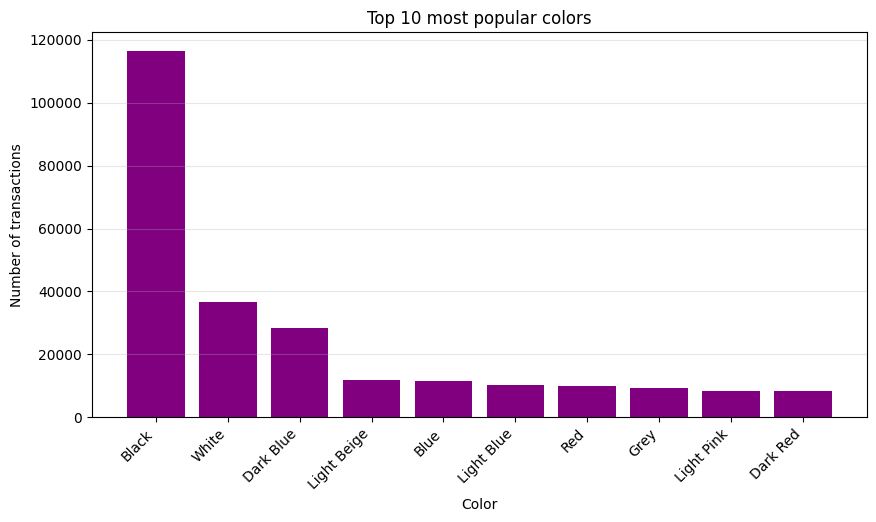

In [69]:
color_pd = df.groupBy("colour_group_name").count().orderBy(F.desc("count")).limit(10).toPandas()
plt.figure(figsize=(10,5))
plt.bar(color_pd['colour_group_name'], color_pd['count'], color='purple')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 most popular colors")
plt.xlabel("Color")
plt.ylabel("Number of transactions")
plt.grid(axis='y', alpha=0.3)
plt.show()

Black is by far the most popular color, followed by White and Dark Blue. This suggests that neutral and dark colors dominate sales, which can guide inventory and marketing decisions.

In [70]:
top_product_types = df.groupBy("product_type_name") \
    .agg(F.sum("price").alias("revenue")) \
    .orderBy(F.desc("revenue")) \
    .limit(10)

top_product_types.show(truncate=False)

+-----------------+------------------+
|product_type_name|revenue           |
+-----------------+------------------+
|Trousers         |1584.8587627117877|
|Dress            |1188.2181694915025|
|Sweater          |867.5875762711836 |
|Blouse           |493.0956949152566 |
|Jacket           |418.0511525423692 |
|Skirt            |342.1530677966116 |
|T-shirt          |324.51540677966597|
|Top              |321.6338135593214 |
|Shorts           |312.98832203389884|
|Bra              |307.7484406779639 |
+-----------------+------------------+



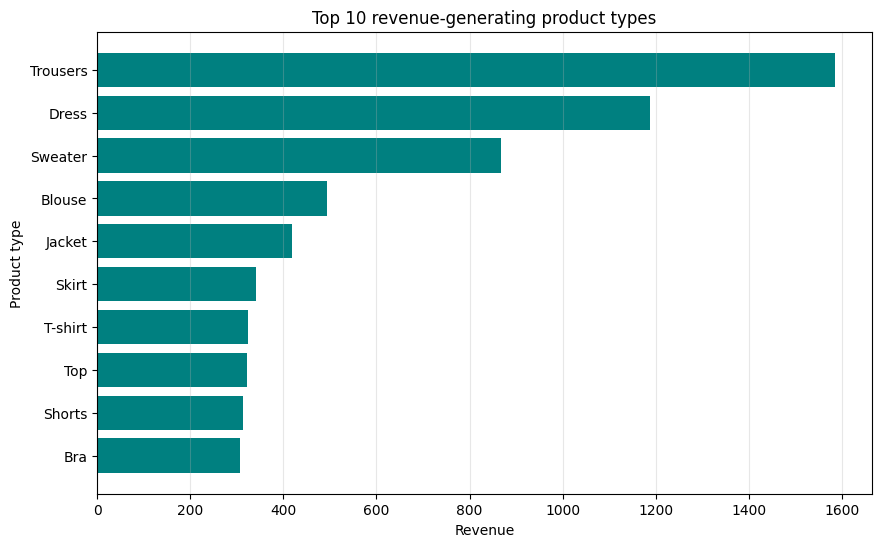

In [72]:
top_prod_pd = top_product_types.toPandas()
plt.figure(figsize=(10,6))
plt.barh(top_prod_pd['product_type_name'], top_prod_pd['revenue'], color='teal')
plt.xlabel("Revenue")
plt.ylabel("Product type")
plt.title("Top 10 revenue-generating product types")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.show()

Trousers, Dresses, and Sweaters generate the highest revenue, indicating that essential and staple clothing items drive the majority of sales. Less revenue comes from items like bras and shorts, suggesting that focus on high-demand clothing categories could optimize profits.

**Conclusion 4**

Analysis shows that upper body garments have the highest repeat purchase loyalty, while black, white, and dark blue dominate color preferences. Revenue is concentrated in staple items like Trousers, Dresses, and Sweaters, confirming that core apparel categories drive both customer retention and revenue. These insights can guide marketing, inventory planning, and product strategy.